GOAL: Using User Reviews to classify user status 

Algorithms: 

    -mnb = MultinomialNB()
    
    -rf = RandomForestClassifier()
    
    -svc = SVC() 
    
    -ada = AdaBoostClassifier()  
    
    -logit = LogisticRegression()
    
    -gbc = GradientBoostingClassifier()


In [1]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from collections import Counter
from collections import defaultdict

# NLP Tools 
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from confusion_mat import show_confusion_matrix
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


# Evaluation - Optimization Tools
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report,confusion_matrix
from sklearn.preprocessing import normalize, scale, StandardScaler, Normalizer
from sklearn.grid_search import GridSearchCV

# Classification Algorithms
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

Populating the interactive namespace from numpy and matplotlib


/Users/Charlotte/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Charlotte/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
user = pd.read_pickle('data/user')
review = pd.read_pickle('data/review') # 32k
# business =pd.read_pickle('data/business')

# Vectorize Text Data

In [3]:
elite_userid = user['user_id'].ix[user['elite_status'] == 1]

In [4]:
review['elite_status'] = np.where(review['user_id'].isin(elite_userid), 1, 0)

In [5]:
X = review['text']
y = review['elite_status']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [6]:
vectorizer = TfidfVectorizer()
vect_X_train = vectorizer.fit_transform(X_train)
vect_X_test = vectorizer.transform(X_test)

# Select Best Models

In [10]:
def cross_val(model,X_train,y_train):
   
    model.fit(X_train,y_train)

    print(str(model).split('(')[0],'CV:')
    print('-- Accuracy:', round((cross_val_score(model, X_train, y_train, cv=3,scoring='accuracy').mean()), 3),
          '| Recall:', round(cross_val_score(model, X_train, y_train, cv=3, scoring='recall').mean(), 3),
          '| Precision:', round(cross_val_score(model, X_train, y_train, cv=3, scoring='precision').mean(), 3),
          '| f1:', round(cross_val_score(model, X_train, y_train, cv=3, scoring='f1').mean(), 3),
         '| auc:',round(cross_val_score(model, X_train, y_train, cv=3, scoring= 'roc_auc').mean(), 3))
            

In [11]:
mnb = MultinomialNB()
rf = RandomForestClassifier()
svc = SVC() # takes forever to run 
ada = AdaBoostClassifier()  
logit = LogisticRegression()
gbc = GradientBoostingClassifier() # takes forever to run 

In [11]:
cross_val(rf,vect_X_train, y_train)

RandomForestClassifier CV:
-- Accuracy: 0.775 | Recall: 0.049 | Precision: 0.503 | f1: 0.098 | auc: 0.661


In [12]:
cross_val(ada,vect_X_train, y_train) 

AdaBoostClassifier CV:
-- Accuracy: 0.78 | Recall: 0.232 | Precision: 0.544 | f1: 0.325 | auc: 0.734


In [12]:
cross_val(mnb,vect_X_train, y_train)

MultinomialNB CV:
-- Accuracy: 0.774 | Recall: 0.013 | Precision: 0.484 | f1: 0.025 | auc: 0.508


In [13]:
cross_val(logit,vect_X_train, y_train)

LogisticRegression CV:
-- Accuracy: 0.792 | Recall: 0.193 | Precision: 0.627 | f1: 0.295 | auc: 0.77


#### LogisticRegression and AdaBoostClassfier are selected to the next round due to their the highest score in accuracy and f1

# Hyperparameters Tuning

In [14]:
def gs_abc(X_train,y_train):
    param = [{'learning_rate': [0.5,0.8,1],'n_estimators': [30,50]}]
    grid_search = GridSearchCV(AdaBoostClassifier(), param_grid = param, verbose = 1, cv = 3,n_jobs= -1, scoring = 'accuracy')
    grid_search.fit(X_train, y_train)
    param = grid_search.best_params_
    return param


In [16]:
gs_abc(vect_X_train, y_train) 

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  4.2min finished


{'learning_rate': 0.5, 'n_estimators': 50}

In [19]:
#since learning rate and n_estimators are at the border , I want to run another GS 

In [17]:
def gs_abc(X_train,y_train):
    param = [{'learning_rate': [0.3,0.5],'n_estimators': [50,100]}]
    grid_search = GridSearchCV(AdaBoostClassifier(), param_grid = param, verbose = 1, cv = 3,n_jobs= -1, scoring = 'accuracy')
    grid_search.fit(X_train, y_train)
    param = grid_search.best_params_
    return param


In [18]:
gs_abc(vect_X_train, y_train) 

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.2min finished


{'learning_rate': 0.5, 'n_estimators': 100}

In [24]:
def gs_logit(X_train,y_train):
    param_grid = [{'C': [0.1, 1, 10] }]
    grid_search = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    param = grid_search.best_params_
    return param


In [25]:
gs_logit(vect_X_train, y_train) 

{'C': 1}

In [29]:
def gs_logit(X_train,y_train):
    param_grid = [{'C': [ 1, 3,5] ,'penalty': ['l1','l2']}]
    grid_search = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    param = grid_search.best_params_
    return param


In [30]:
gs_logit(vect_X_train, y_train) 

{'C': 1, 'penalty': 'l2'}

# Final Testing

In [12]:
def fit_model(model,X_train,y_train,X_test,y_test):
    "Fit Model --- Return Evaluation Metrics"
    
    model = model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    prob = model.predict_proba(X_test)
    

    print(str(model).split('(')[0],':')
    print('Train | Accuracy:', round(accuracy_score(y_train, train_pred),3),
          '| Recall',round(recall_score(y_train, train_pred),3),
          '| Precision',round(precision_score(y_train, train_pred),3),
          '| f1',round(f1_score(y_train, train_pred),3))

    print('Test | Accuracy:', round(accuracy_score(y_test, test_pred),3),
          '| Recall',round(recall_score(y_test, test_pred),3),
          '| Precision',round(precision_score(y_test, test_pred),3),
          '| f1',round(f1_score(y_test, test_pred),3))
    
    return test_pred, prob[:,1]

    


In [13]:
def plot_roc(y_test, pred_test):
    fpr, tpr, _= roc_curve(y_test, pred_test)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr, label = 'area %.2f' %roc_auc)
    plt.plot(np.linspace(0,1,10),np.linspace(0,1,10))
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend(loc = 'lower right')
    plt.show()

In [14]:
logit_tuned = LogisticRegression(C = 1, penalty = 'l2')
ada_tuned = AdaBoostClassifier(learning_rate = 0.5, n_estimators = 500)

In [15]:
logit_test_pred, logit_prob = fit_model(logit_tuned, vect_X_train, y_train,vect_X_test, y_test)

LogisticRegression :
Train | Accuracy: 0.83 | Recall 0.322 | Precision 0.816 | f1 0.462
Test | Accuracy: 0.793 | Recall 0.252 | Precision 0.641 | f1 0.362


In [16]:
ada_test_pred, ada_prob  = fit_model(ada_tuned, vect_X_train, y_train,vect_X_test, y_test)

AdaBoostClassifier :
Train | Accuracy: 0.821 | Recall 0.351 | Precision 0.711 | f1 0.47
Test | Accuracy: 0.786 | Recall 0.28 | Precision 0.584 | f1 0.378


In [18]:
logit_confusion = confusion_matrix(y_test, logit_test_pred )
ada_confusion = confusion_matrix(y_test, ada_test_pred )

In [19]:
print(classification_report(y_test, logit_test_pred ))

             precision    recall  f1-score   support

          0       0.81      0.96      0.88      5001
          1       0.64      0.25      0.36      1522

avg / total       0.77      0.79      0.76      6523



# Evaluation

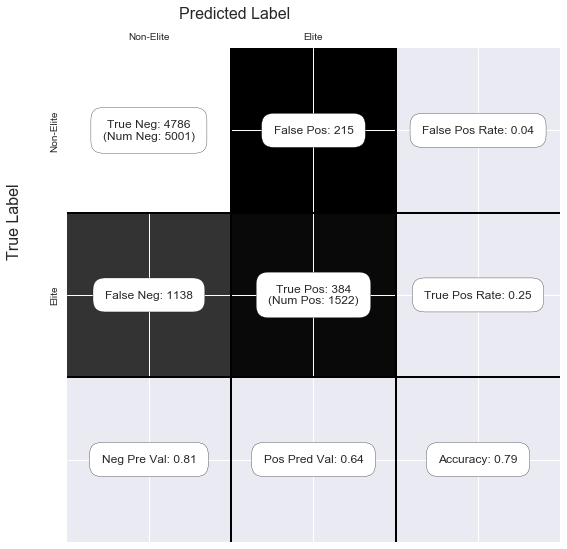

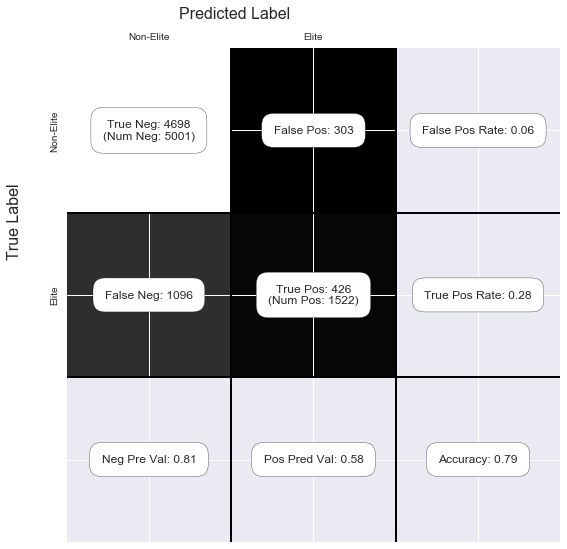

In [20]:
show_confusion_matrix(logit_confusion,class_labels=["Non-Elite", "Elite"])
show_confusion_matrix(ada_confusion,class_labels=["Non-Elite", "Elite"])

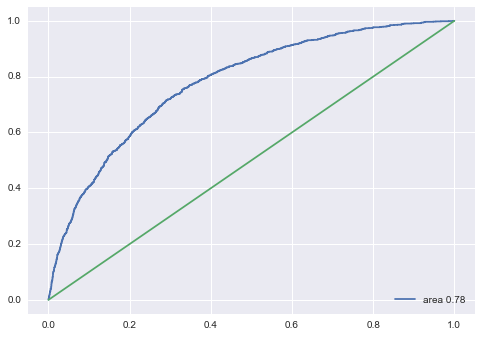

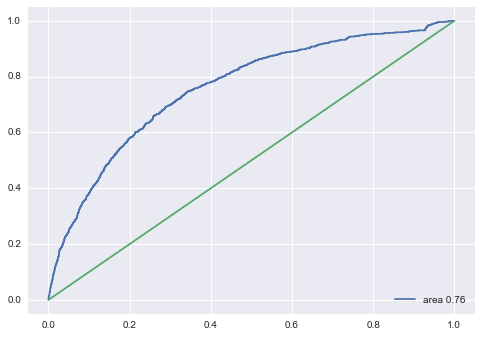

In [48]:
plot_roc(y_test, logit_prob )
plot_roc(y_test, ada_prob )